# AITA Toxicity Analysis

## Prepare Environment

In [6]:
from tqdm import tqdm
import json
from transformers import pipeline


In [4]:
# log into huggingface to load models and datasets

from huggingface_hub import login
login()

## Load Toxigen RoBERTa Model

In [7]:
# load toxigen roberta model
toxigen_roberta = pipeline("text-classification", model="tomh/toxigen_roberta", truncation=True, device_map='cuda')

# LABEL 0 = NON-TOXIC
# LABEL 1 = TOXIC

## Load Generation Results and Get Predictions and References

In [8]:
with open('generation_results\\flanT5_xxl_binary_generation_results.json') as f:
    data = json.load(f)

In [9]:
predictions = data['prediction_texts']
references = data['reference_texts']

In [10]:
toxicity_scores = {'predictions': [], 'references': []}

for i in tqdm(range(len(predictions))):
    prediction_toxicity = toxigen_roberta(predictions[i])[0]
    reference_toxicity = toxigen_roberta(references[i])[0]
    toxicity_scores['predictions'].append([prediction_toxicity['label'], prediction_toxicity['score']])
    toxicity_scores['references'].append([reference_toxicity['label'], reference_toxicity['score']])

  0%|          | 4/9229 [00:00<11:21, 13.53it/s]--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\mattb\AppData\Local\Programs\Python\Python311\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mattb\AppData\Local\Programs\Python\Python311\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\mattb\AppData\Local\Programs\Python\Python311\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mattb\AppData\Local\Programs\Python\Python311\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\matt

In [11]:
# get toxic predictions and references
toxic_predictions = [score for score in toxicity_scores['predictions'] if score[0] == 'LABEL_1']
toxic_references = [score for score in toxicity_scores['references'] if score[0] == 'LABEL_1']

# get nontoxic predictions and references
non_toxic_predictions = [score for score in toxicity_scores['predictions'] if score[0] == 'LABEL_0']
non_toxic_references = [score for score in toxicity_scores['references'] if score[0] == 'LABEL_0']

In [12]:
import json

# get percentages of toxic/non-toxic samples in predictions and references
percent_toxic_predictions = len(toxic_predictions) / len(predictions)
percent_toxic_references = len(toxic_references) / len(references)

toxicity_percentages = {
    'percent_toxic_predictions': percent_toxic_predictions,
    'percent_toxic_references': percent_toxic_references
}
toxicity_percentages
with open('toxicity_eval_results/flanT5_xxl_binary/toxicity_scores.json', 'w') as json_file:
    json.dump(toxicity_percentages, json_file, indent=4)

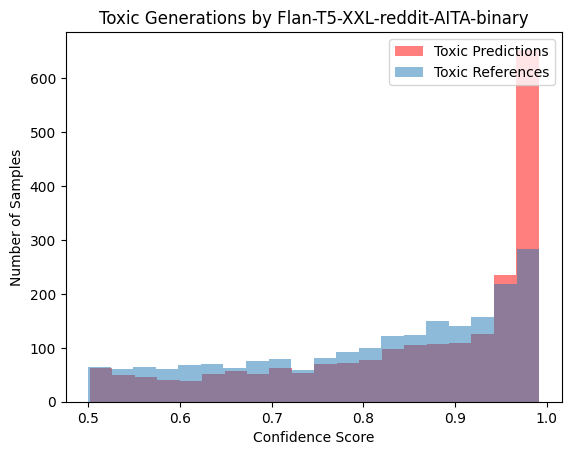

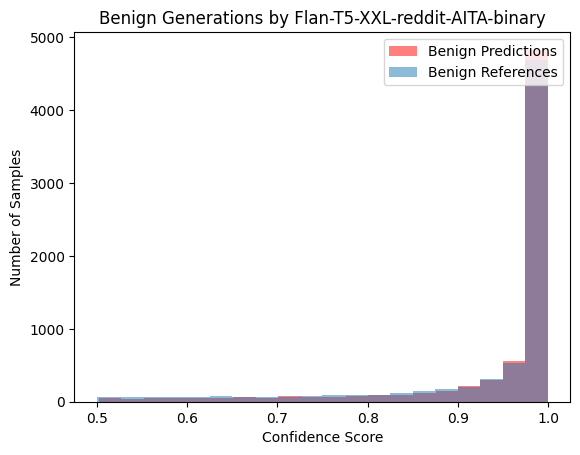

In [13]:
import matplotlib.pyplot as plt

# histogram of the toxic prediction and reference scores 
prediction_toxic_scores = [score[1] for score in toxic_predictions]
reference_toxic_scores = [score[1] for score in toxic_references]

plt.hist(prediction_toxic_scores, bins=20, alpha=0.5, label='Toxic Predictions', color='red')
plt.hist(reference_toxic_scores, bins=20, alpha=0.5, label='Toxic References')
plt.legend(loc='upper right')
plt.title('Toxic Generations by Flan-T5-XXL-reddit-AITA-binary')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Samples')
plt.savefig(f'toxicity_eval_results/flanT5_xxl_binary/toxic_responses.png')
plt.show()

# histogram of the non-toxic prediction reference scores
prediction_non_toxic_scores = [score[1] for score in non_toxic_predictions]
reference_non_toxic_scores = [score[1] for score in non_toxic_references]

plt.hist(prediction_non_toxic_scores, bins=20, alpha=0.5, label='Benign Predictions', color='red')
plt.hist(reference_non_toxic_scores, bins=20, alpha=0.5, label='Benign References')
plt.legend(loc='upper right')
plt.title(f'Benign Generations by Flan-T5-XXL-reddit-AITA-binary')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Samples')
plt.savefig(f'toxicity_eval_results/flanT5_xxl_binary/benign_responses.png')
plt.show()